In [1]:
%matplotlib notebook

In [2]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import random

import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [5]:
#GRID = Polygon([(1750,1600), (1750,2000), (2200, 2000), (2200, 1600)])
#GRID = Polygon([(1450,1800),(1450,2000),(2200,2000),(2200,1800)])



MALES = [11, 17, 20, 24, 26, 28, 30, 33, 34]
FEMALES = [10, 14, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

### Levanto el chekpoint en pandas

In [9]:
birds_data_complete = pd.read_parquet('tmp/checkpoint-dig.parquet')
birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

### Obtengo las predicciones

In [10]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(birds_data_complete)], axis=1).values

### Calculo si la prediccion cayó dentro de la grilla

In [11]:
def set_prediction_grid_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])
        grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
        '''
        if GRID.contains(point):
            grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
        else:
            grid_pred = np.insert(prediction, 8,'out_grid', axis=0)
        '''
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo en que cada posible pareja esta junta

In [12]:
SAMPLE_SIZE = 1000000

def calculate_distance(x0,y0,x1,y1):
    return math.sqrt((x0-x1)**2+(y0-y1)**2)

def get_bird_timestamp_in_grid(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in zip(bird_data.time, bird_data.x, bird_data.y):
    #for row in bird_data['time']:
        real_time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append((datetime.strftime(res, '%Y-%m-%d %H:%M:%S'), row[1], row[2]))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time', 'x', 'y'])

def get_sample_grid_matches_per_bird(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

    matches_per_bird = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
        timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner', lsuffix='_male', rsuffix='_female')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, [])
            current_matches.append(calculate_distance(row['x_male'], row['y_male'], row['x_female'], row['y_female']))
            female_matches[tag] = current_matches

        matches_per_bird[female_bird] = female_matches
    temp = matches_per_bird.copy()
    for f in FEMALES:
        for m in MALES:
            list_distances = matches_per_bird[f].get(m, [])
            if len(list_distances) > SAMPLE_SIZE:
                list_distances = random.sample(list_distances, SAMPLE_SIZE)
            matches_per_bird[f][m] = list_distances
    return matches_per_bird, temp




### Imprimo matriz de confusion

In [13]:
def show_confusion_matrices(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    matrix_count = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        matrix_count[i] = []
        for m in MALES:
            list_distances = matches_per_female[FEMALES[i]].get(m, []) # float('inf')
            matrix_res[i].append(np.mean(list_distances))
            matrix_count[i].append(len(list_distances))
            
    
    plt.figure(figsize=(10,20))
    
    plt.subplot(4, 1, 1)
    plt.title('Birds mean distances')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd = matrix_res_pd.round(0)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, cbar_kws={'label': 'meters'})
    ax.set(xlabel='Males', ylabel='Females')

    ### Cantidad de muestras por pareja
    plt.subplot(4, 1, 2)
    plt.title('Birds matches count')
    matrix_res_pd = pd.DataFrame(matrix_count)
    matrix_res_pd = matrix_res_pd.round(0)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
    ax.set(xlabel='Males', ylabel='Females')


    ### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
    ### con cualquier hembra estuvieron juntos
    plt.subplot(4, 1, 3)
    plt.title('Male distance distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')


    ### Igual, pero con las hembras
    plt.subplot(4, 1, 4)
    plt.title('Female distance distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')




In [14]:
def evaluate_grid_sample_distance(predictions, delta_time=5):
    predictions = set_prediction_grid_classification(predictions)
    matches_per_bird = get_sample_grid_matches_per_bird(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

### Muestro las mejores parejas para cada hembra

In [15]:
delta_time=5
predictions_2 = set_prediction_grid_classification(predictions)
matches_per_bird_2, data = get_sample_grid_matches_per_bird(predictions_2, delta_time)

In [16]:
MIN_COOCURRENCIES = 100

matrix_res = [[]] * len(FEMALES)
matrix_count = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res[i] = []
    matrix_count[i] = []
    for m in MALES:
        list_distances = matches_per_bird_2[FEMALES[i]].get(m, []) # float('inf')
        coocurr_count = len(list_distances)
        mean_distance = np.mean(list_distances)
        if MIN_COOCURRENCIES <= coocurr_count:
            matrix_res[i].append(mean_distance)
        else:
            matrix_res[i].append(np.nan)
        #matrix_count[i].append(coocurr_countz)

In [17]:
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd = matrix_res_pd.round(0)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)

In [18]:
data_list = []
for k, v in data.items():
    for male, dist in v.items():
        for d in dist:
            data_list.append([k,male,d])

In [19]:
data_df = pd.DataFrame(data_list, columns=['female', 'male', 'distance'])

<IPython.core.display.Javascript object>


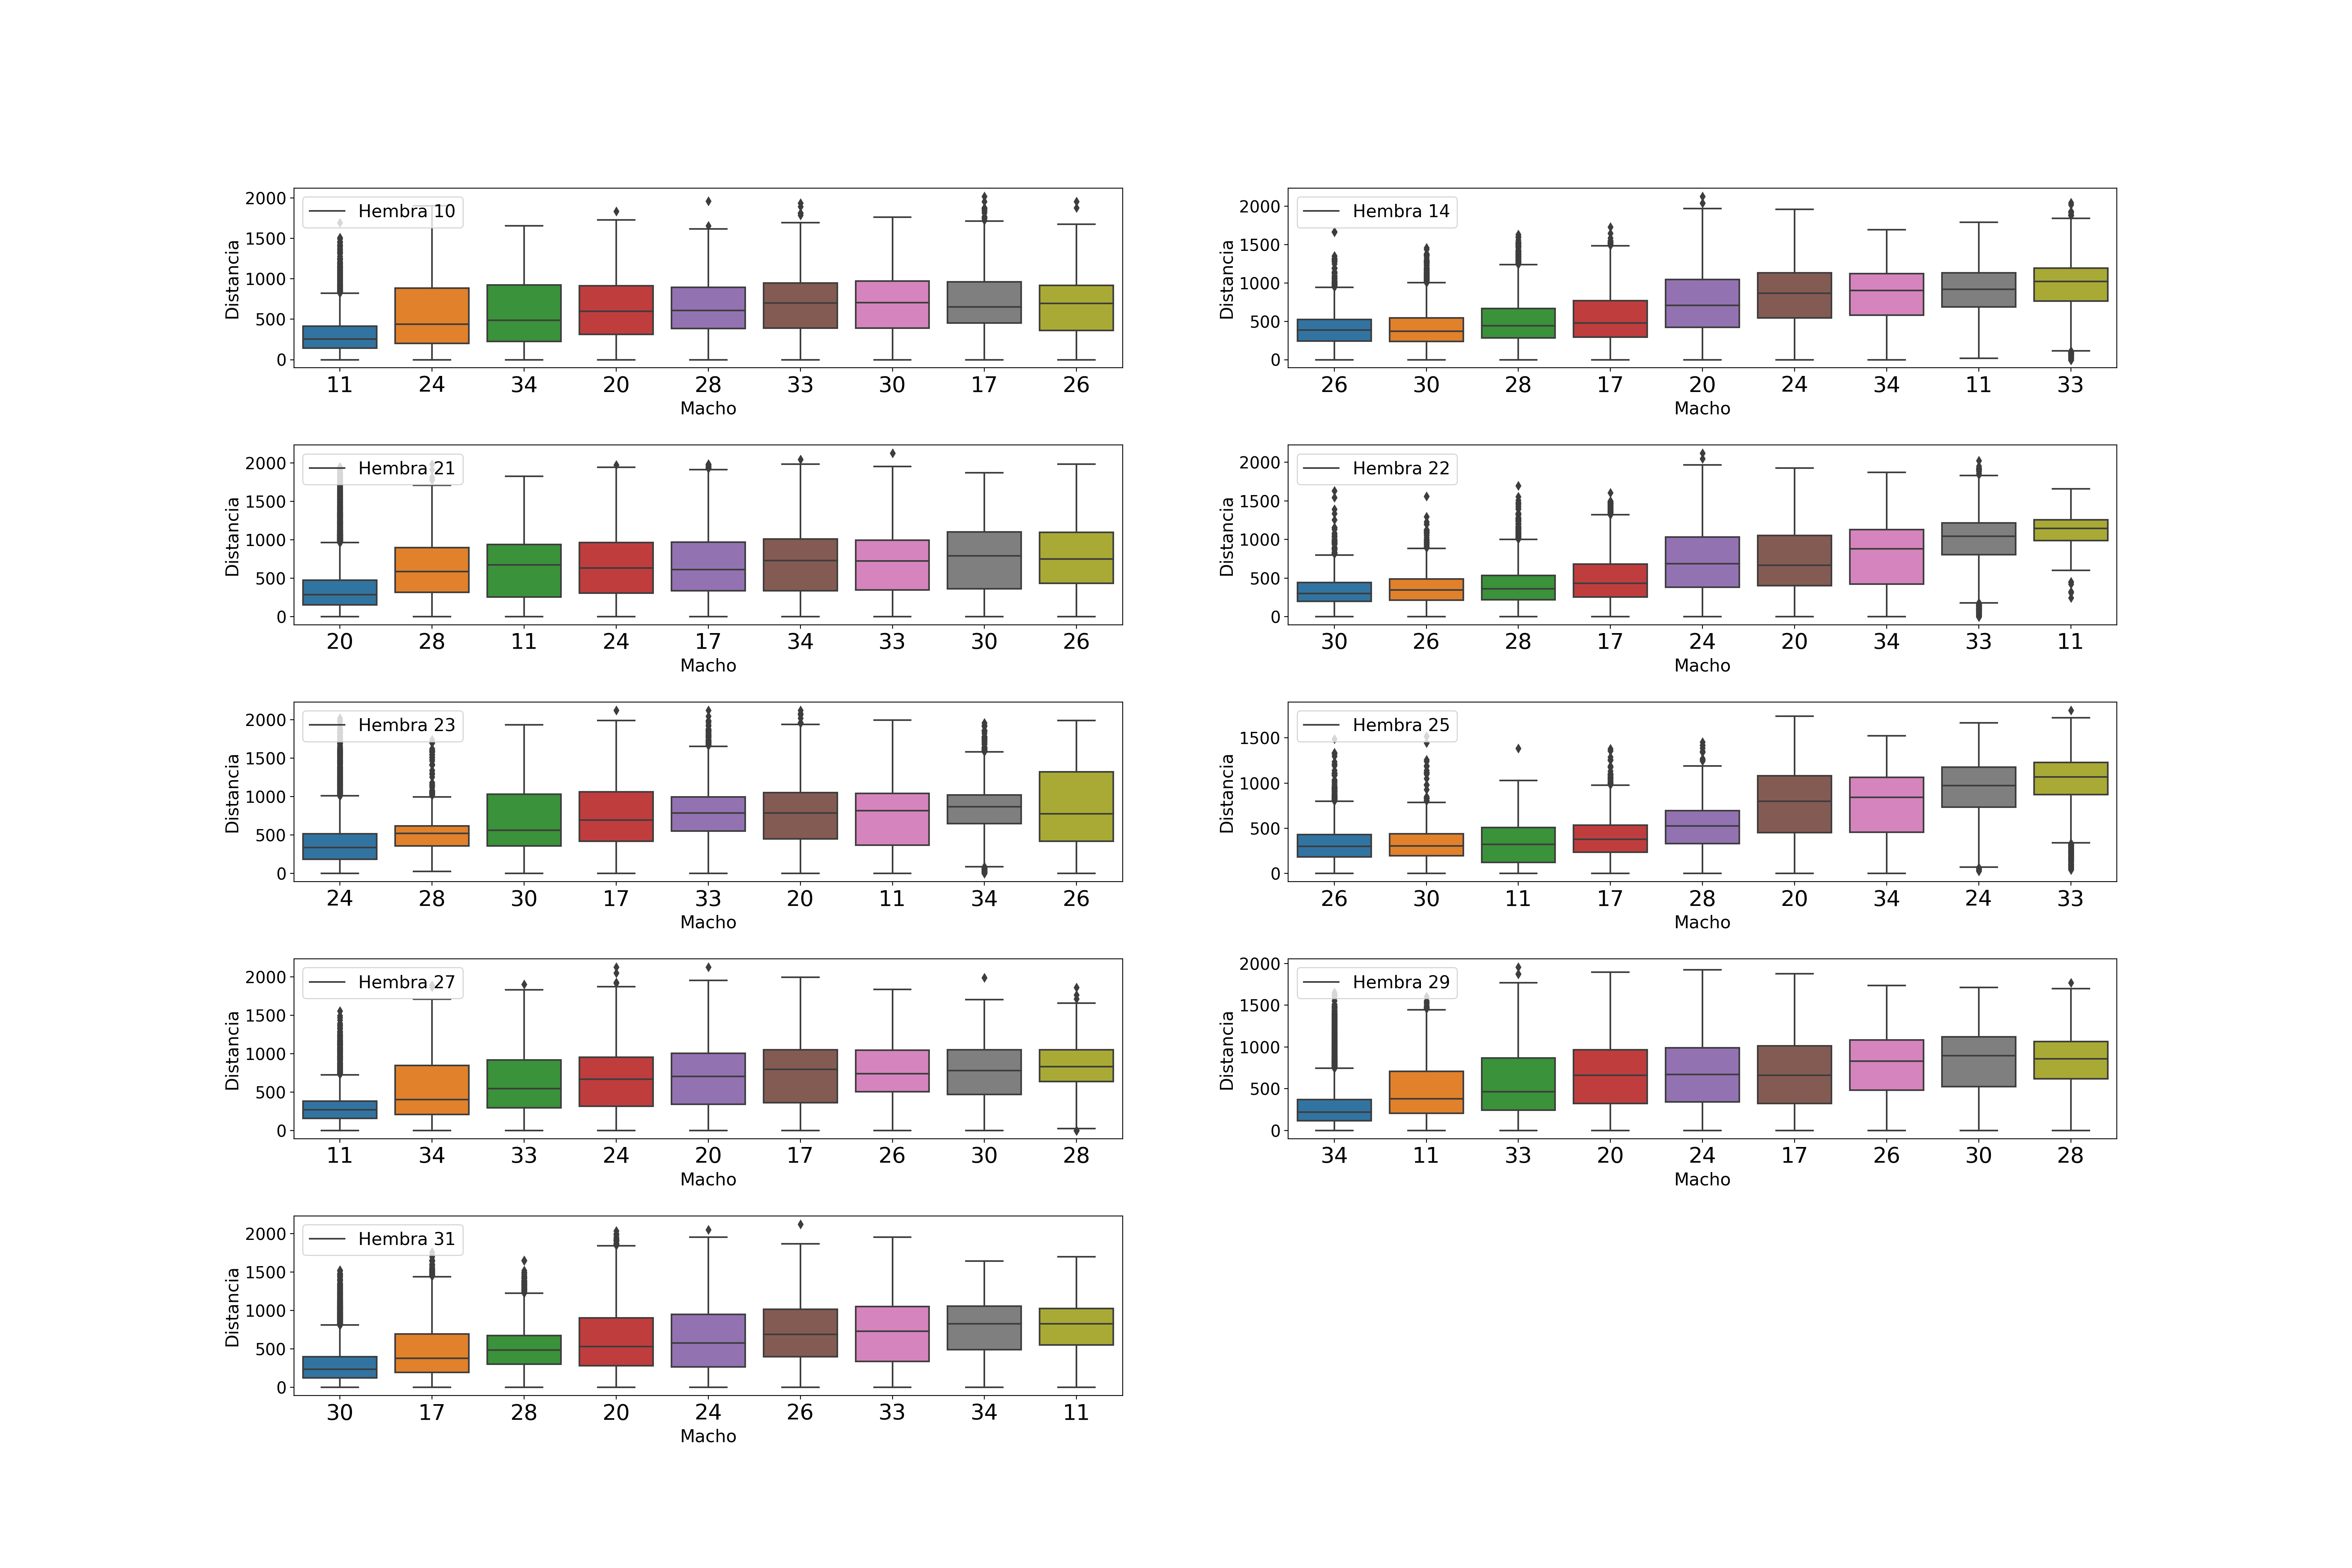

In [21]:
fig, axs = plt.subplots(5,2, figsize=(30,20))
fig.delaxes(axs[4,1])
for i,f in enumerate(FEMALES):
    ax = axs.flatten()[i]
    female_data_df = data_df[data_df['female'] == f].copy()
    males_sorted_by_dist = list(female_data_df.groupby('male').agg({'distance':'mean'}).sort_values(by='distance').index)
    female_data_df['order'] = female_data_df['male'].apply(lambda x: males_sorted_by_dist.index(x))
    #female_data_df.sort_values(by='order').boxplot(column=['distance'], by='order', ax=ax)
    sn.boxplot(y='distance', x='order', data=female_data_df,ax=ax)
    ax.set_xticklabels(males_sorted_by_dist)
    ax.set_xlabel('Macho', fontsize=16)
    ax.set_ylabel('Distancia', fontsize=16)
    ax.legend([f'Hembra {f}'], loc='upper left', prop={'size': 16})
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=15)
fig.suptitle('')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.43)
fig.savefig('prettier/pruebaa.png', bbox_inches='tight')
#fig.savefig('prettier/BoxPlotDistanciaEntrePajaros.png', bbox_inches='tight')

